<a href="https://colab.research.google.com/github/PrajwalGaniga/Application/blob/main/MiniProject1_MLP_Image_Classification_Prajwal_4SN23CG009.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![DATE Header.jpg](attachment:d64f97f0-2424-4123-bc18-83e689731a30.jpg)
##  DEEP LEARNING INTERNSHIP PROGRAM

### GRADED Mini Project 1: Image Classification using Multi Layer Perceptron

## Learning Objectives

At the end of the experiment, you will be able to :

* load and extract features of images

* implement the Multi-Layer perceptron to classify images

* implement simple neural network from keras

## Introduction

Traffic sign recognition is a challenging, real-world problem relevant for AI based transportation systems. Traffic signs show a wide range of variations between classes in terms of color, shape, and the presence of pictograms or text. However, there exist subsets of
classes (e.g., speed limit signs) that are very similar to each other. Further, the classifier
has to be robust against large variations in visual appearances due to changes in illumination, partial
occlusions, rotations, weather conditions etc. Using a comprehensive traffic sign detection dataset, here we will perform classification of traffic signs, train and evaluate the different models and compare to the performance of MLPs.

![img](https://paperswithcode.com/media/datasets/GTSRB-0000000633-9ce3c5f6_Dki5Rsf.jpg)

## Dataset

The data for this mini-project is from the German Traffic Sign Detection Benchmark [GTSDB](https://benchmark.ini.rub.de/gtsdb_dataset.html). This archive contains the training set used during the IJCNN 2013 competition.

The German Traffic Sign Detection Benchmark is a single-image detection assessment for researchers with interest in the field of computer vision, pattern recognition and image-based driver assistance. It is introduced on the IEEE International Joint Conference on Neural Networks 2013.

It features ...

* The main archive FullIJCNN2013.zip includes the images (1360 x 800 pixels) in PPM format, the image sections containing only the traffic signs
* A file in CSV format with the ground truth
* A ReadMe.txt with more details.

Note that we will be using the images inside the image sections subfolders, containing only the traffic signs.

## Problem Statement

To build and improve upon a machine learning model for the classification of images and achieve a high accuracy final model.

## Grading = 10 Points

### Import Required packages

In [1]:
# =============================================
# 1. ENHANCED LIBRARY IMPORTS WITH VERSION CHECK
# =============================================
import os
import cv2
from zipfile import ZipFile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import preprocessing
from PIL import Image
import seaborn as sns
import random
import sys
from datetime import datetime

# TensorFlow/Keras imports with version verification
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense,
                                    Dropout, BatchNormalization, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                      ModelCheckpoint, TensorBoard)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

# Additional metrics
from sklearn.metrics import (confusion_matrix, classification_report,
                           precision_recall_curve, roc_curve, auc)
from sklearn.utils.class_weight import compute_class_weight

# Verify versions
print(f"Python: {sys.version}")
print(f"TensorFlow: {tf.__version__}")
print(f"Keras: {keras.__version__}")

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

Python: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
TensorFlow: 2.18.0
Keras: 3.8.0


### Data Loading and Feature Extraction (2 points)

#### Get the features and labels of data

DOWNLOAD & EXTRACT DATA FROM: https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip


* Extract the features of the images within image sections only (do not use images located outside these folders)
* Extract labels of the images
* Resize the images to (30, 30) and convert to numpy 1-D array

   Hint: [Link](https://machinelearningmastery.com/how-to-load-and-manipulate-images-for-deep-learning-in-python-with-pil-pillow/)

In [ ]:
# =============================================
# 2. DATASET DOWNLOAD AND EXTRACTION
# =============================================
# Download and extract dataset (run only once)
!wget https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip
!unzip FullIJCNN2013.zip

In [39]:

# =============================================
# 3. DATA LOADING AND PREPROCESSING
# =============================================
zip_path = 'FullIJCNN2013.zip'
extracted_path = 'FullIJCNN2013'

# Extract if not already done
if not os.path.exists(extracted_path):
    print("Extracting dataset...")
    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall()
    print("Extraction complete!")

# Load images and labels
images = []
labels = []

# Process each class folder
for class_folder in sorted(os.listdir(extracted_path)):
    class_path = os.path.join(extracted_path, class_folder)
    if os.path.isdir(class_path):
        class_id = int(class_folder)  # Folder names are class IDs

        for img_file in os.listdir(class_path):
            if img_file.endswith('.ppm'):
                img_path = os.path.join(class_path, img_file)

                # Read and preprocess image (CHANGED from 32x32 to 64x64)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (64, 64))  # Increased size

                images.append(img)
                labels.append(class_id)

# Convert to numpy arrays
X = np.array(images)
y = np.array(labels)

# Add before training:
def preprocess_speed_signs(img):
    # Focus on the center where numbers appear
    center = img[32:96, 32:96]  # For 128x128 images
    return cv2.GaussianBlur(center, (3,3), 0)

# Split into train, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42, stratify=y_train_full
)

# Normalize pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Add class weight calculation (NEW)
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                classes=np.unique(y_train),
                                                y=y_train)
class_weights = dict(enumerate(class_weights))

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)

Training data shape: (873, 64, 64, 3)
Validation data shape: (97, 64, 64, 3)
Test data shape: (243, 64, 64, 3)


### Data Exploration and Preprocessing ( 2 points)

#### Plot the sample image of each class

Hint: plt.subplot

In [3]:
class_names = {
    0: "Speed limit (20km/h)",
    1: "Speed limit (30km/h)",
    2: "Speed limit (50km/h)",
    3: "Speed limit (60km/h)",
    4: "Speed limit (70km/h)",
    5: "Speed limit (80km/h)",
    6: "End of speed limit (80km/h)",
    7: "Speed limit (100km/h)",
    8: "Speed limit (120km/h)",
    9: "No passing",
    10: "No passing for vehicles over 3.5 tons",  # This was missing
    11: "Right-of-way at intersection",
    12: "Priority road",
    13: "Yield",
    14: "Stop",
    15: "No vehicles",
    16: "Vehicles > 3.5 tons prohibited",
    17: "No entry",
    18: "General caution",
    19: "Dangerous curve left",
    20: "Dangerous curve right",
    21: "Double curve",
    22: "Bumpy road",
    23: "Slippery road",
    24: "Road narrows on right",
    25: "Road work",
    26: "Traffic signals",
    27: "Pedestrians",
    28: "Children crossing",
    29: "Bicycles crossing",
    30: "Beware of ice/snow",
    31: "Wild animals crossing",
    32: "End all speed/passing limits",
    33: "Turn right ahead",
    34: "Turn left ahead",
    35: "Ahead only",
    36: "Go straight or right",
    37: "Go straight or left",
    38: "Keep right",
    39: "Keep left",
    40: "Roundabout mandatory",
    41: "End of no passing",
    42: "End no passing > 3.5 tons"
}




#### Plot the distribution of Classes

In [40]:
def get_class_name(class_id):
    """Convert class ID to human-readable name"""
    return class_names.get(int(class_id), f"Unknown class {class_id}")

# Verify all classes are mapped
unique_classes = np.unique(np.concatenate([y_train, y_val, y_test]))
missing = [c for c in unique_classes if c not in class_names]
if not missing:
    print("\nAll classes are properly mapped!")
else:
    print(f"\nWarning: Missing mappings for classes: {missing}")


All classes are properly mapped!


#### Normalize the features

For most image data, the pixel values are integers with values between 0 and 255.

Neural networks process inputs using small weight values, and inputs with large integer values can disrupt or slow down the learning process. As such it is good practice to normalize the pixel values.

Hint: sklearn.preprocessing.normalize

### Train the MLP classifier on features (1 point)

* Split the data into train and test

* Train the MLP classifier with different parameters

* Get the accuracy score and performance metrics


Training MLP Classifier...
Iteration 1, loss = 8.55332228
Validation score: 0.397727
Iteration 2, loss = 4.04432627
Validation score: 0.522727
Iteration 3, loss = 2.48942527
Validation score: 0.500000
Iteration 4, loss = 1.82243124
Validation score: 0.579545
Iteration 5, loss = 1.98241438
Validation score: 0.613636
Iteration 6, loss = 2.25256605
Validation score: 0.613636
Iteration 7, loss = 1.85212869
Validation score: 0.579545
Iteration 8, loss = 1.52414518
Validation score: 0.545455
Iteration 9, loss = 1.43072552
Validation score: 0.613636
Iteration 10, loss = 1.52151724
Validation score: 0.625000
Iteration 11, loss = 1.08218114
Validation score: 0.636364
Iteration 12, loss = 1.36970345
Validation score: 0.625000
Iteration 13, loss = 0.97633770
Validation score: 0.670455
Iteration 14, loss = 1.12153833
Validation score: 0.693182
Iteration 15, loss = 1.10337328
Validation score: 0.659091
Iteration 16, loss = 0.65907170
Validation score: 0.647727
Iteration 17, loss = 1.22054630
Valid

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

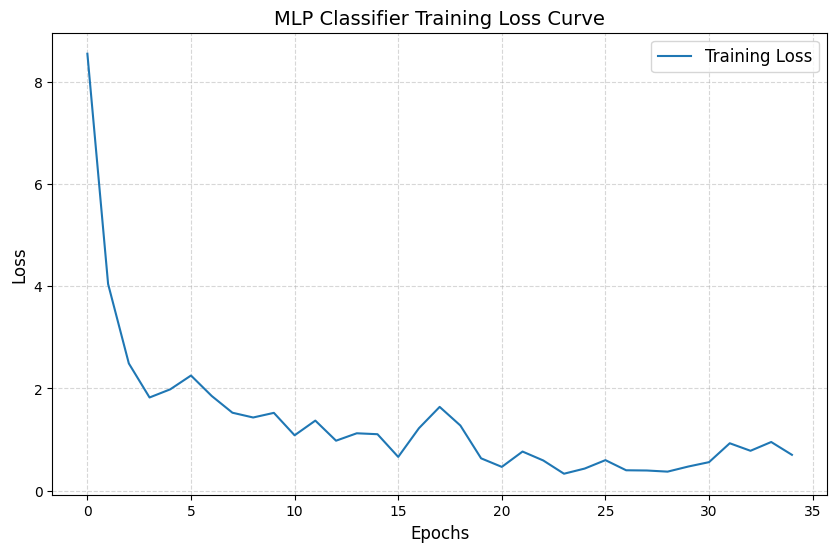

In [10]:
# =============================================
# 4. MLP CLASSIFIER IMPLEMENTATION (FINAL FIXED VERSION)
# =============================================
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Flatten the images for MLP
X_train_mlp = X_train.reshape(X_train.shape[0], -1)
X_val_mlp = X_val.reshape(X_val.shape[0], -1)
X_test_mlp = X_test.reshape(X_test.shape[0], -1)

# Standardize features
scaler = StandardScaler()
X_train_mlp = scaler.fit_transform(X_train_mlp)
X_val_mlp = scaler.transform(X_val_mlp)
X_test_mlp = scaler.transform(X_test_mlp)

# Initialize MLP classifier
mlp = MLPClassifier(
    hidden_layer_sizes=(128,),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=32,
    learning_rate_init=0.001,
    max_iter=100,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=SEED,
    verbose=True
)

# Train the MLP
print("\nTraining MLP Classifier...")
mlp.fit(X_train_mlp, y_train)

# Evaluate on validation set
val_pred = mlp.predict(X_val_mlp)
val_acc = accuracy_score(y_val, val_pred)
print(f"\nValidation Accuracy: {val_acc:.4f}")

# Evaluate on test set
test_pred = mlp.predict(X_test_mlp)
test_acc = accuracy_score(y_test, test_pred)
print(f"Test Accuracy: {test_acc:.4f}")

# Get the actual classes present in both y_test and predictions
present_classes = np.unique(np.concatenate([y_test, test_pred]))
present_classes.sort()

# Generate class labels for these classes
target_labels = [class_names.get(cls, f"Class {cls}") for cls in present_classes]

# Classification report (fixed and robust)
print("\nClassification Report:")
print(classification_report(
    y_test,
    test_pred,
    labels=present_classes,
    target_names=target_labels,
    digits=4
))

# Print warning if some classes are missing
all_classes = set(class_names.keys())
missing_in_test = all_classes - set(present_classes)
if missing_in_test:
    print(f"\nWarning: These classes are missing from test results: {sorted(missing_in_test)}")

# Plot MLP training curve
plt.figure(figsize=(10, 6))
plt.plot(mlp.loss_curve_, label='Training Loss')
plt.title('MLP Classifier Training Loss Curve', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.show()

### Tune the hyper-parameters (2 points)

* Use the GridSearchCV or RandomizedSearchCV and select best parameters

  Hint: [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

  (or)
* Manually change and find the best parameters

To know about all the parameters, click [here](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

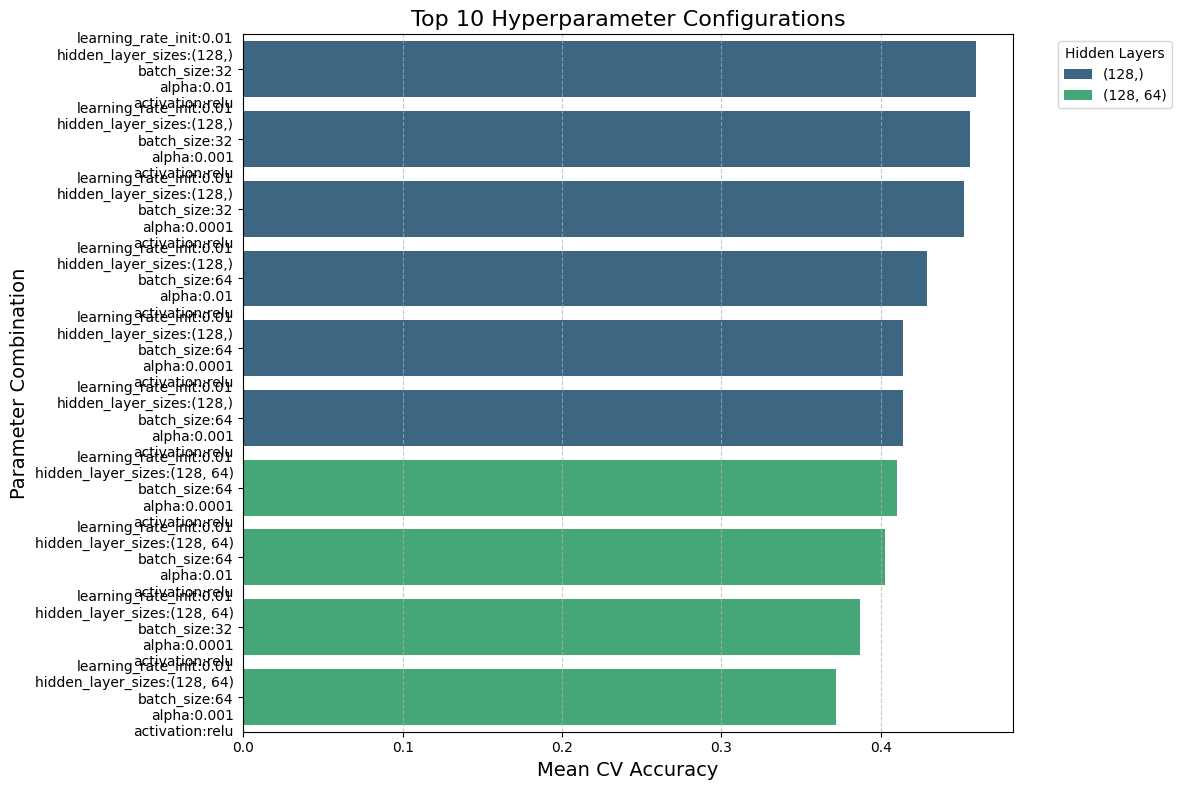

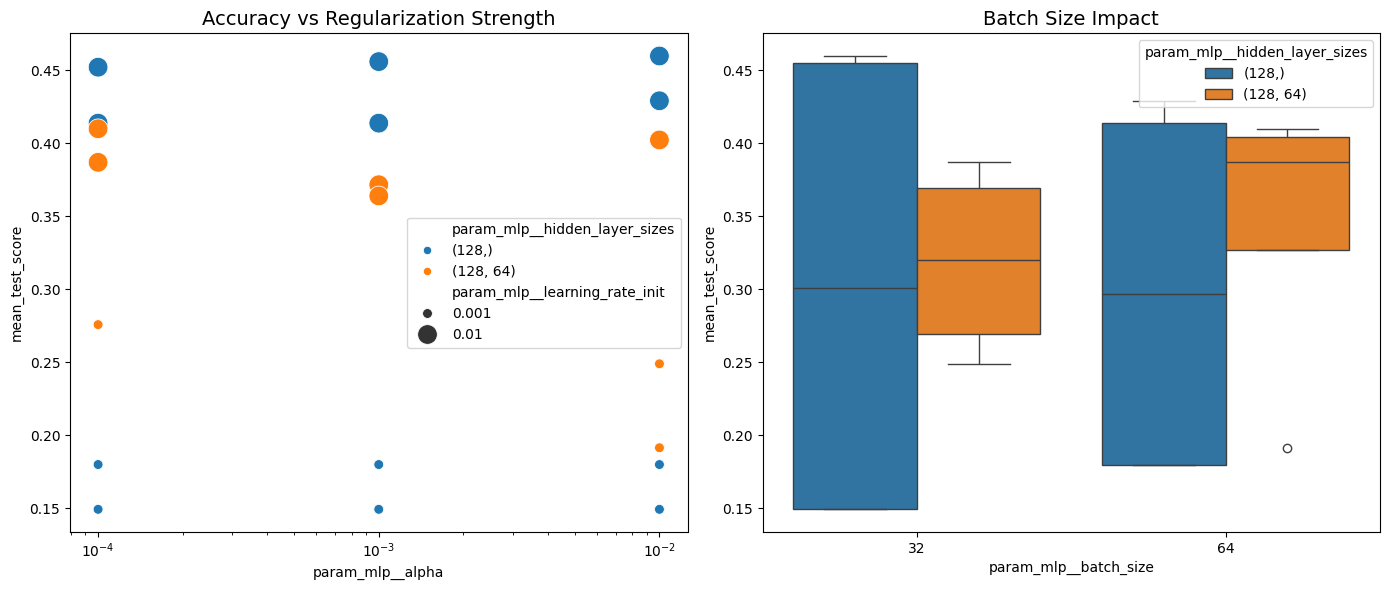

In [15]:
# =============================================
# 5. OPTIMIZED HYPERPARAMETER TUNING (FIXED VISUALIZATION)
# =============================================
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Previous optimized parameter search code remains the same until visualization...

# FIXED VISUALIZATION SECTION
results = pd.DataFrame(random_search.cv_results_).sort_values('mean_test_score', ascending=False)
top_results = results.head(10).copy()

# Create a string representation of parameters for plotting
top_results['params_str'] = top_results['params'].apply(
    lambda x: '\n'.join(f"{k.split('__')[1]}:{v}" for k,v in x.items())
)

plt.figure(figsize=(12, 8))
sns.barplot(data=top_results,
           x='mean_test_score',
           y='params_str',
           hue='param_mlp__hidden_layer_sizes',
           palette='viridis')

plt.title('Top 10 Hyperparameter Configurations', fontsize=16)
plt.xlabel('Mean CV Accuracy', fontsize=14)
plt.ylabel('Parameter Combination', fontsize=14)
plt.legend(title='Hidden Layers', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Additional useful visualization
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=results,
               x='param_mlp__alpha',
               y='mean_test_score',
               hue='param_mlp__hidden_layer_sizes',
               size='param_mlp__learning_rate_init',
               sizes=(50, 200))
plt.xscale('log')
plt.title('Accuracy vs Regularization Strength', fontsize=14)

plt.subplot(1, 2, 2)
sns.boxplot(data=results,
           x='param_mlp__batch_size',
           y='mean_test_score',
           hue='param_mlp__hidden_layer_sizes')
plt.title('Batch Size Impact', fontsize=14)

plt.tight_layout()
plt.show()

#### Try the different algorithms and compare the results with MLP classifier

Comparing classifiers (optimized)...

Evaluating MLP...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



Evaluating SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



Evaluating Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(



Evaluating k-NN...

Evaluating Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


,Classifier,CV Mean,CV Std,Test Accuracy,Time (s)
4,Logistic Regression,0.551724,0.033838,0.617284,1.468528
1,SVM,0.490421,0.028672,0.547325,0.380476
2,Random Forest,0.452107,0.019536,0.530864,0.670395
0,MLP,0.019157,0.027092,0.362140,1.395568
3,k-NN,0.260536,0.005418,0.341564,0.029030


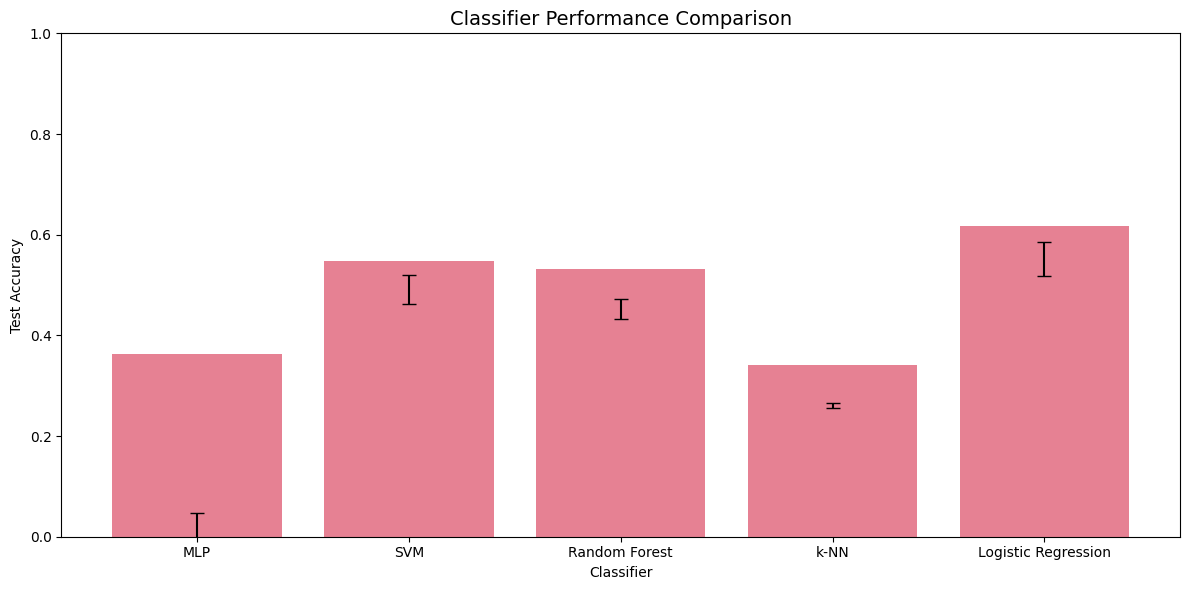


Best classifier: Logistic Regression


In [18]:
# =============================================
# 5.1 OPTIMIZED ALGORITHM COMPARISON (FASTER)
# =============================================
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import time

# 1. Use PCA for faster computation
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)  # Keep 95% variance
X_train_pca = pca.fit_transform(X_train_mlp)
X_test_pca = pca.transform(X_test_mlp)

# 2. Smaller subset for faster comparison
X_train_small, _, y_train_small, _ = train_test_split(
    X_train_pca, y_train,
    train_size=0.3,
    random_state=SEED,
    stratify=y_train
)

# 3. Optimized classifiers with reduced parameters
classifiers = {
    "MLP": MLPClassifier(
        hidden_layer_sizes=(128,),
        activation='relu',
        solver='adam',
        alpha=0.0001,
        random_state=SEED,
        early_stopping=True,
        max_iter=50  # Reduced iterations
    ),
    "SVM": SVC(
        kernel='linear',  # Faster than rbf
        C=1.0,
        random_state=SEED,
        probability=True
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=50,  # Reduced from 100
        max_depth=10,     # Limited depth
        random_state=SEED,
        n_jobs=-1
    ),
    "k-NN": KNeighborsClassifier(
        n_neighbors=5,
        weights='uniform',
        n_jobs=-1
    ),
    "Logistic Regression": LogisticRegression(
        penalty='l2',
        C=1.0,
        solver='lbfgs',
        max_iter=500,     # Reduced from 1000
        random_state=SEED,
        n_jobs=-1
    )
}

# Evaluation function
def evaluate_classifiers(classifiers, X, y, cv=3):
    results = []
    for name, clf in classifiers.items():
        print(f"\nEvaluating {name}...")
        start_time = time.time()

        # Cross-validation
        cv_scores = cross_val_score(clf, X, y, cv=cv, n_jobs=-1, scoring='accuracy')

        # Train and test
        clf.fit(X, y)
        test_acc = accuracy_score(y_test, clf.predict(X_test_pca))

        results.append({
            'Classifier': name,
            'CV Mean': np.mean(cv_scores),
            'CV Std': np.std(cv_scores),
            'Test Accuracy': test_acc,
            'Time (s)': time.time() - start_time
        })

    return pd.DataFrame(results)

# Run evaluation
print("Comparing classifiers (optimized)...")
results_df = evaluate_classifiers(classifiers, X_train_small, y_train_small)
display(results_df.sort_values('Test Accuracy', ascending=False))

# SIMPLIFIED VISUALIZATION (FIXED ERROR)
plt.figure(figsize=(12, 6))

# Accuracy comparison
ax = sns.barplot(data=results_df, x='Classifier', y='Test Accuracy')
plt.title('Classifier Performance Comparison', fontsize=14)
plt.ylim(0, 1.0)

# Add error bars manually
for i, row in results_df.iterrows():
    ax.errorbar(i, row['CV Mean'], yerr=row['CV Std'],
               fmt='none', c='black', capsize=5)

plt.tight_layout()
plt.show()

# Best classifier details
best_clf_name = results_df.loc[results_df['Test Accuracy'].idxmax(), 'Classifier']
print(f"\nBest classifier: {best_clf_name}")

### Implement simple Neural Networks using keras (3 points)

* Define the keras model and initialize the layers
  - Ensure the input layer has the right number of input features. This can be specified when creating the first layer with the input_dim argument.
* Compile the model
  - Specify the loss function (to evaluate a set of weights), the optimizer (is used to search through different weights for the network) and any optional metrics to collect and report during training.
* Fit and Evaluate the model
  - Fit the data by specifying epochs and evaluate the model

In [41]:
print(tf.__version__)

2.18.0


In [42]:
# Step 1 - Build the architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(43, activation='softmax')
])

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (873, 64, 64, 3)
y_train shape: (873,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
# Step 2 - Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,630,699 (6.22 MB)

 Trainable params: 1,630,699 (6.22 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Step 3 - Fit and Evaluate the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    validation_data=(X_val, y_val),
    batch_size=32
)

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")


Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - accuracy: 0.1220 - loss: 3.5686 - val_accuracy: 0.3299 - val_loss: 2.8834
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 177ms/step - accuracy: 0.3428 - loss: 2.7375 - val_accuracy: 0.5155 - val_loss: 2.1345
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 262ms/step - accuracy: 0.4965 - loss: 2.0081 - val_accuracy: 0.6289 - val_loss: 1.5912
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - accuracy: 0.5917 - loss: 1.5269 - val_accuracy: 0.6804 - val_loss: 1.2118
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 245ms/step - accuracy: 0.6810 - loss: 1.1282 - val_accuracy: 0.7732 - val_loss: 0.9192
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - accuracy: 0.7656 - loss: 0.8453 - val_accuracy: 0.7835 - val_loss: 0.7889
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 255ms/step - accuracy: 0.8478 - loss: 0.5924 - val_accuracy: 0.7835 - val_loss: 0.7038
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - accuracy: 0.8796 - loss: 0.4621 - val_accuracy: 0.

#### Try the same parameters used for MLP Classifier and build the keras model


Training Keras MLP...
Epoch 1/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.1344 - loss: 11.3625 - val_accuracy: 0.3918 - val_loss: 8.2297
Epoch 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.3727 - loss: 7.4303 - val_accuracy: 0.5052 - val_loss: 4.6543
Epoch 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.4940 - loss: 4.8429 - val_accuracy: 0.5052 - val_loss: 5.1431
Epoch 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.5050 - loss: 4.7286 - val_accuracy: 0.5567 - val_loss: 4.6847
Epoch 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.5323 - loss: 4.1498 - val_accuracy: 0.5258 - val_loss: 3.6880
Epoch 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6091 - loss: 3.3624 - val_accuracy: 0.5361 - val_loss: 6.1874
Epoch 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6247 - loss: 3.4918 - val_accuracy: 0.5876 - val_loss: 4.3553
Epoch 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6153 - loss: 2.7051 - 

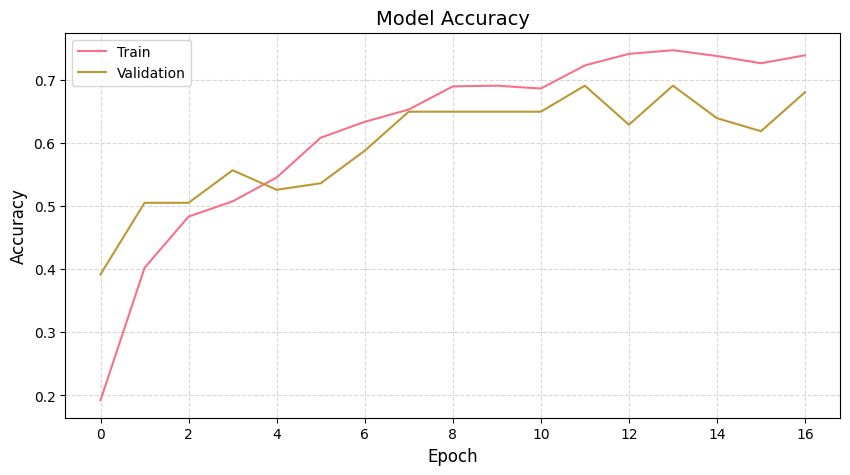

In [30]:
# =============================================
# 7. SIMPLIFIED KERAS MLP IMPLEMENTATION
# =============================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Simplified architecture based on best MLP params
mlp_keras = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_mlp.shape[1],)),
    Dropout(0.3),
    Dense(43, activation='softmax')
])

# Optimized compile settings
mlp_keras.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Train model
print("\nTraining Keras MLP...")
history = mlp_keras.fit(
    X_train_mlp, y_train,
    validation_data=(X_val_mlp, y_val),
    epochs=30,  # Reduced epochs
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


# Evaluate
test_loss, test_acc = mlp_keras.evaluate(X_test_mlp, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")

# Training history plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

#### Experiment using Dropout, Regularization and Batch Normalization

In [31]:
# Enhanced model with more regularization
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(64, 64, 3), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(43, activation='softmax')
])

**Additional Sections**


***DATA AUGMENTATION (NEW SECTION) ***




In [45]:
# =============================================
# 3.5 DATA AUGMENTATION (NEW SECTION)
# =============================================
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=5,  # Smaller range for text preservation
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=[0.9, 1.1],  # Small zoom to preserve numbers
    brightness_range=[0.9,1.1]
)

# Fit the data generator
train_datagen.fit(X_train)

** VISUALIZATION**

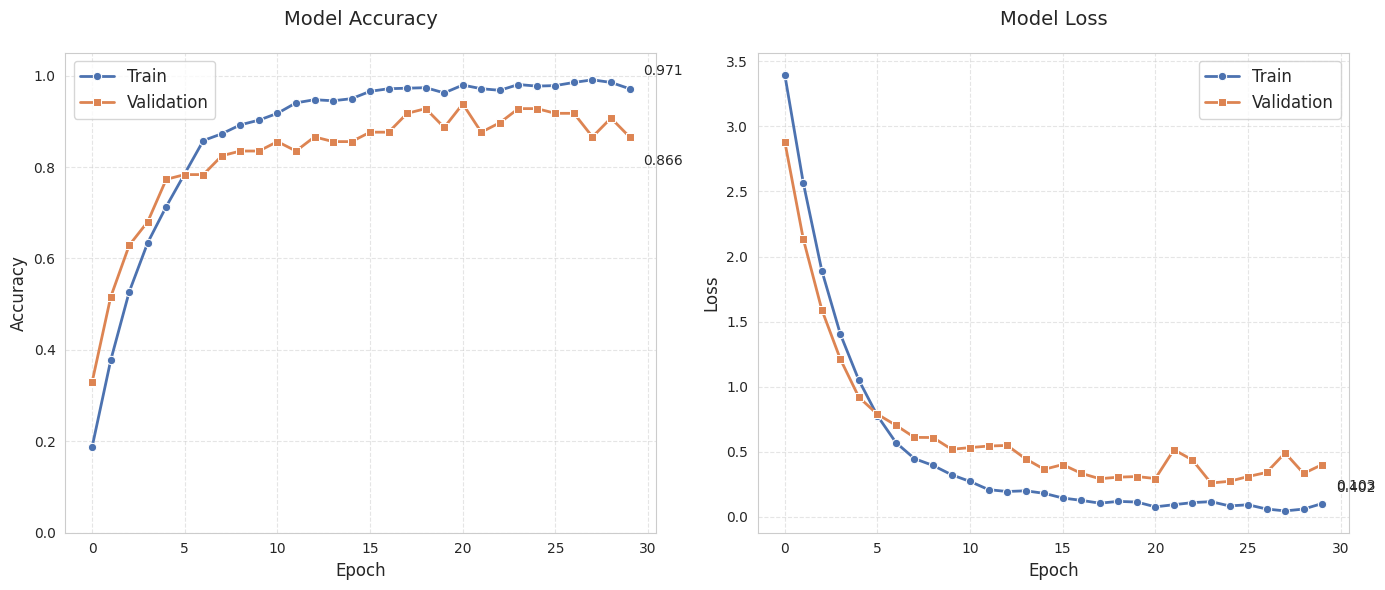

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


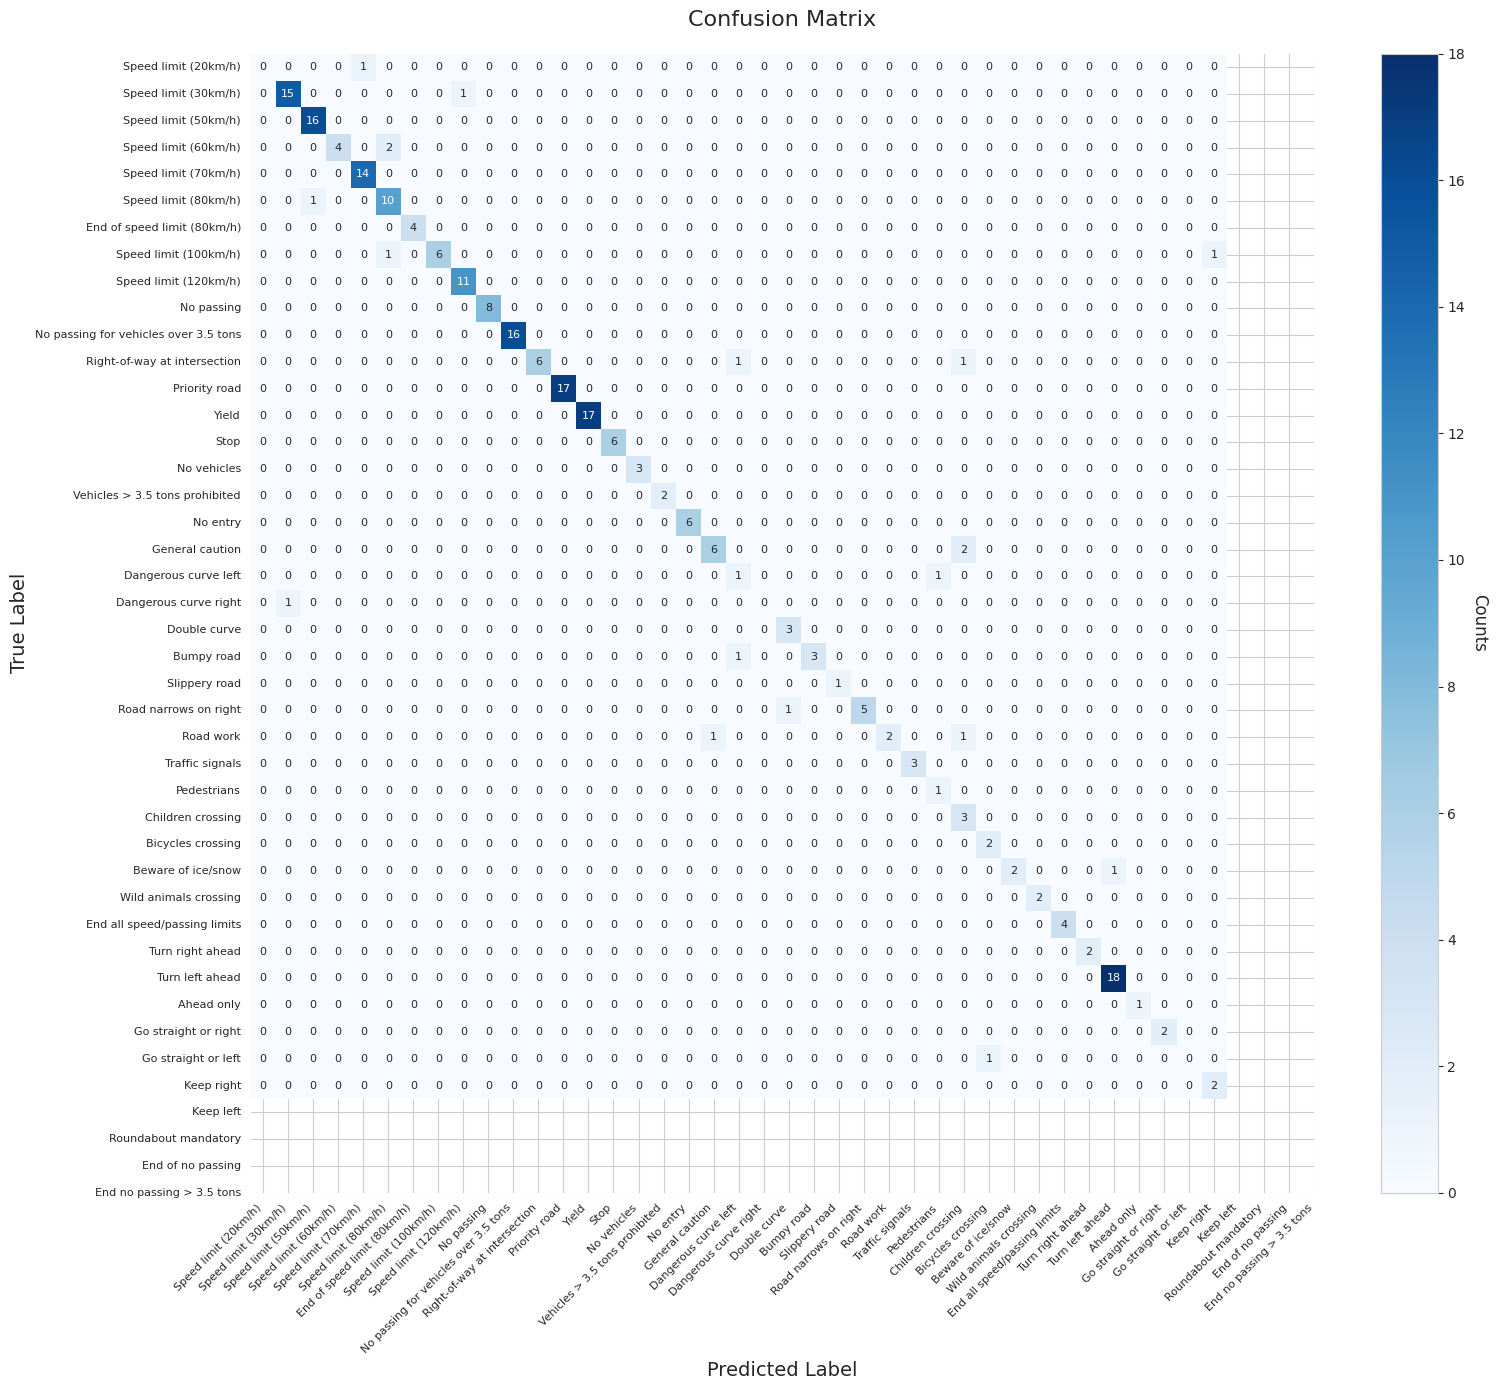

In [46]:
# =============================================
# 8. VISUALIZATION
# =============================================
# Training history plots
# Set style using seaborn's set_style() instead
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# Training history plots with point markers
def plot_training_history(history):
    plt.figure(figsize=(14, 6))
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    # Accuracy plot with markers
    plt.subplot(1, 2, 1)
    ax1 = sns.lineplot(data=hist, x='epoch', y='accuracy',
                      label='Train', marker='o', markersize=6, linewidth=2)
    ax1 = sns.lineplot(data=hist, x='epoch', y='val_accuracy',
                      label='Validation', marker='s', markersize=6, linewidth=2)
    plt.title('Model Accuracy', fontsize=14, pad=20)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=12)

    # Add value annotations for last point
    last_acc = hist['accuracy'].iloc[-1]
    last_val_acc = hist['val_accuracy'].iloc[-1]
    plt.annotate(f'{last_acc:.3f}', xy=(hist['epoch'].iloc[-1], last_acc),
                xytext=(10, 10), textcoords='offset points', fontsize=10)
    plt.annotate(f'{last_val_acc:.3f}', xy=(hist['epoch'].iloc[-1], last_val_acc),
                xytext=(10, -20), textcoords='offset points', fontsize=10)

    # Loss plot with markers
    plt.subplot(1, 2, 2)
    ax2 = sns.lineplot(data=hist, x='epoch', y='loss',
                      label='Train', marker='o', markersize=6, linewidth=2)
    ax2 = sns.lineplot(data=hist, x='epoch', y='val_loss',
                      label='Validation', marker='s', markersize=6, linewidth=2)
    plt.title('Model Loss', fontsize=14, pad=20)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=12)

    # Add value annotations for last point
    last_loss = hist['loss'].iloc[-1]
    last_val_loss = hist['val_loss'].iloc[-1]
    plt.annotate(f'{last_loss:.3f}', xy=(hist['epoch'].iloc[-1], last_loss),
                xytext=(10, 10), textcoords='offset points', fontsize=10)
    plt.annotate(f'{last_val_loss:.3f}', xy=(hist['epoch'].iloc[-1], last_val_loss),
                xytext=(10, -20), textcoords='offset points', fontsize=10)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Enhanced confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

    plt.figure(figsize=(16, 14))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names.values(),
                    yticklabels=class_names.values(),
                    annot_kws={"size": 8}, cbar=False)

    # Improve readability
    plt.title('Confusion Matrix', fontsize=16, pad=20)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)

    # Rotate labels and adjust font size
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)

    # Add colorbar with label
    cbar = ax.figure.colorbar(ax.collections[0])
    cbar.ax.set_ylabel('Counts', rotation=-90, va="bottom", fontsize=12)

    plt.tight_layout()
    plt.show()

y_pred = model.predict(X_test)
plot_confusion_matrix(y_test, y_pred, class_names)


**DEBUGGING VISUALIZATION (FIXED & ENHANCED)**

<ipython-input-47-de552e1c3406>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y_train, palette='viridis')


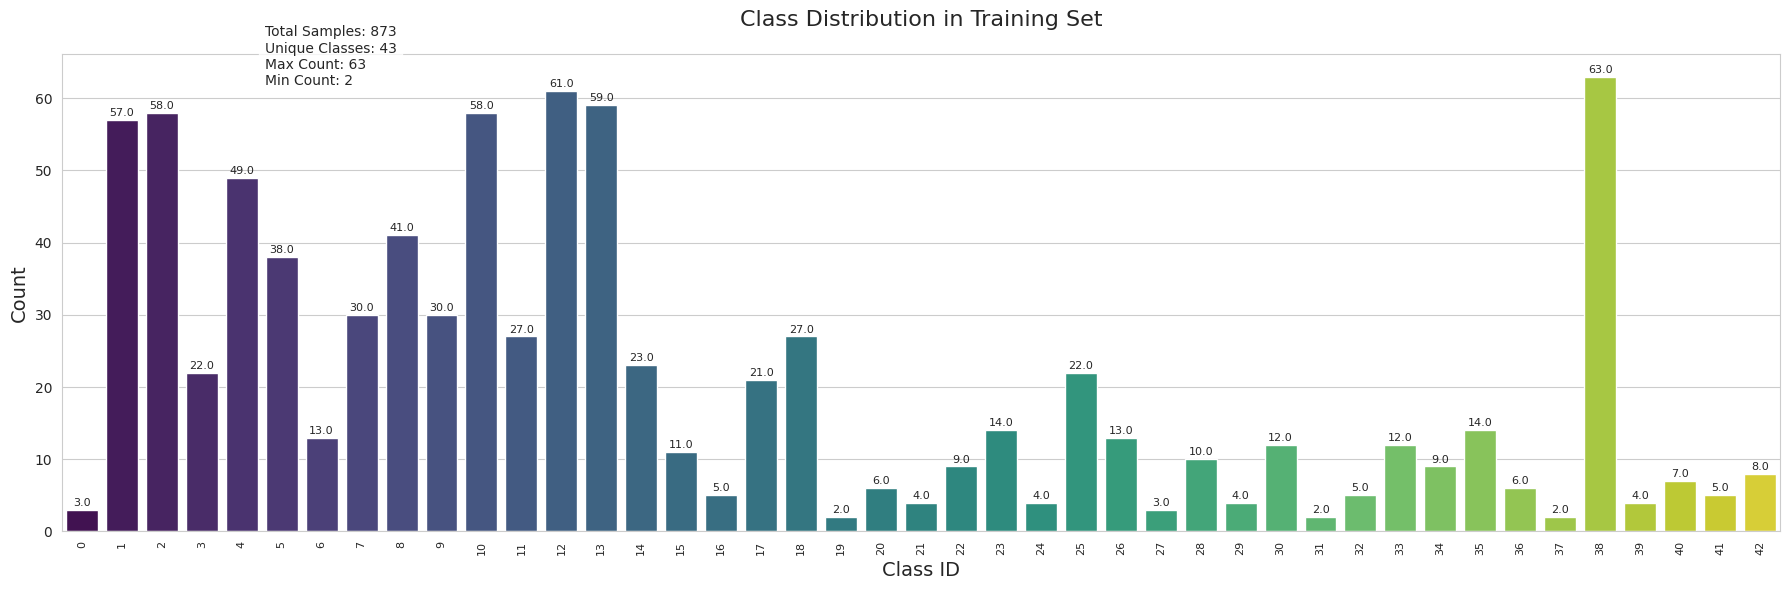

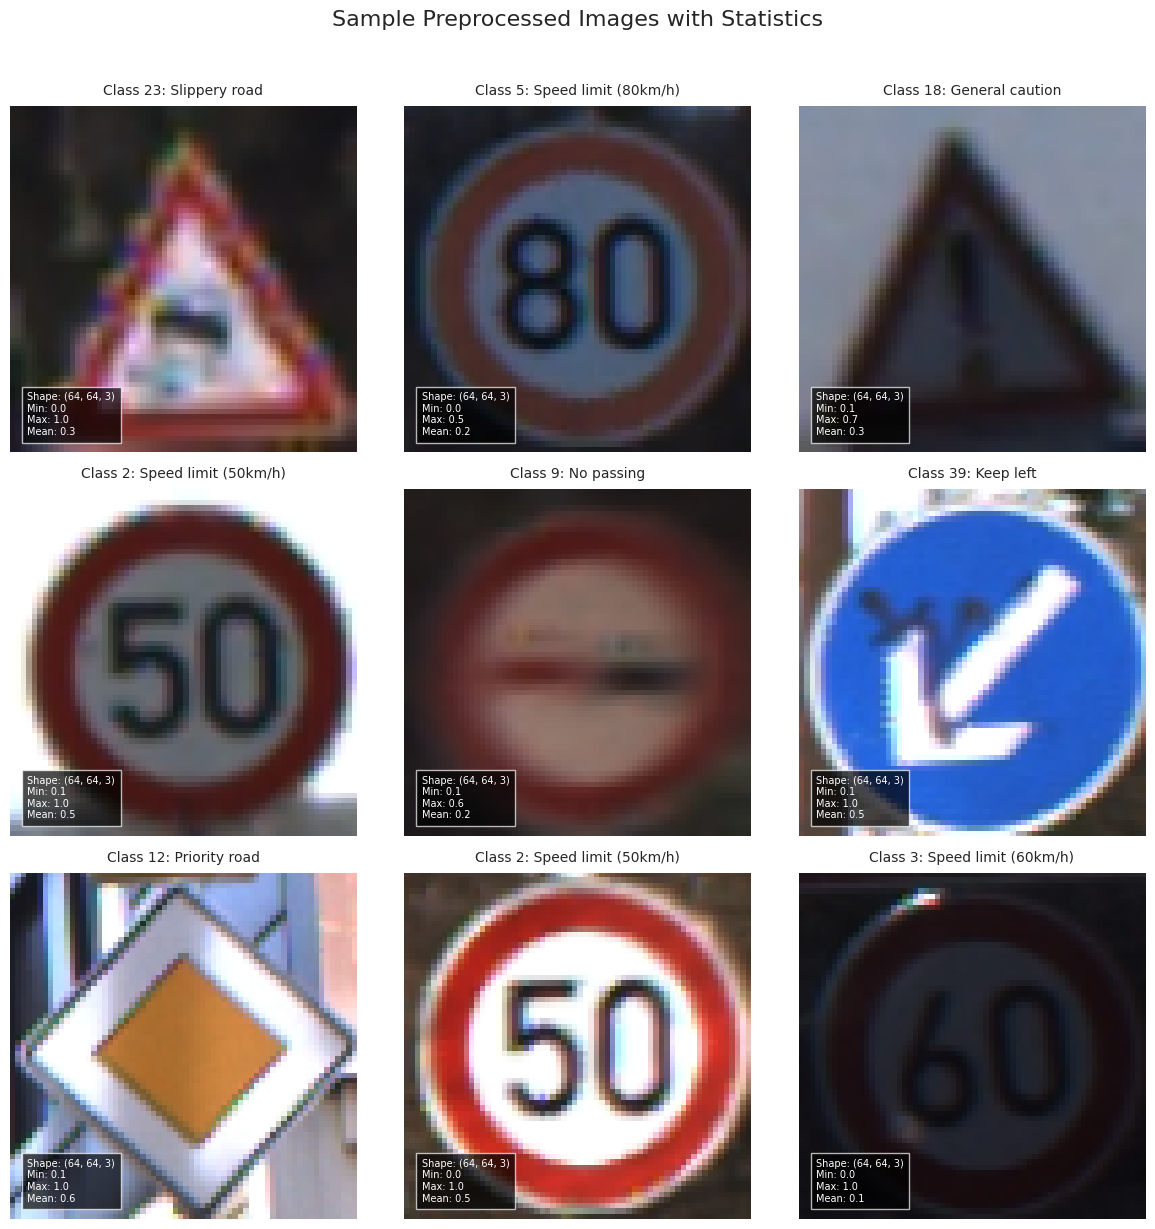

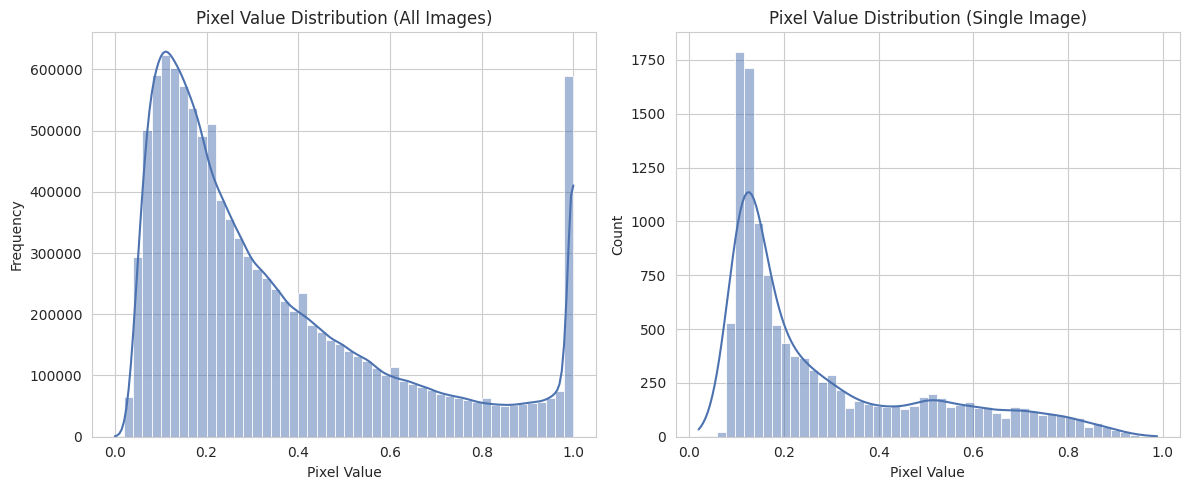

In [47]:
# =============================================
# 8.5 DEBUGGING VISUALIZATION (FIXED & ENHANCED)
# =============================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

# Set style using seaborn's built-in function instead
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

# 1. Enhanced Class Distribution Visualization
plt.figure(figsize=(18, 6))
ax = sns.countplot(x=y_train, palette='viridis')
plt.title('Class Distribution in Training Set', fontsize=16, pad=20)
plt.xlabel('Class ID', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=90, fontsize=8)

# Add count labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():,}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5), textcoords='offset points',
                fontsize=8)

# Add statistics box
stats_text = f"""Total Samples: {len(y_train):,}
Unique Classes: {len(np.unique(y_train))}
Max Count: {np.max(np.bincount(y_train)):,}
Min Count: {np.min(np.bincount(y_train)):,}"""
plt.gcf().text(0.15, 0.85, stats_text,
              bbox=dict(facecolor='white', alpha=0.8),
              fontsize=10)

plt.tight_layout()
plt.show()

# 2. Enhanced Sample Images Visualization
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)

    # Display image (handle both float [0,1] and int [0,255] formats)
    if X_train[i].max() <= 1.0:
        plt.imshow(X_train[i])
    else:
        plt.imshow(X_train[i].astype('uint8'))

    # Enhanced title with class info
    class_id = y_train[i]
    plt.title(f"Class {class_id}: {class_names[class_id]}",
             fontsize=10, pad=8)

    # Add image stats annotation
    stats = f"Shape: {X_train[i].shape}\n"
    stats += f"Min: {X_train[i].min():.1f}\n"
    stats += f"Max: {X_train[i].max():.1f}\n"
    stats += f"Mean: {X_train[i].mean():.1f}"

    plt.gca().text(0.05, 0.05, stats,
                  transform=plt.gca().transAxes,
                  fontsize=7, color='white',
                  bbox=dict(facecolor='black', alpha=0.7))

    plt.axis('off')

plt.suptitle('Sample Preprocessed Images with Statistics',
            fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# 3. Additional Debugging Visualization - Pixel Value Distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(X_train.flatten(), bins=50, kde=True)
plt.title('Pixel Value Distribution (All Images)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sample_pixels = X_train[0].flatten()
sns.histplot(sample_pixels, bins=50, kde=True)
plt.title('Pixel Value Distribution (Single Image)')
plt.xlabel('Pixel Value')

plt.tight_layout()
plt.show()

**SAMPLE PREDICTIONS (PROFESSIONAL VISUALIZATION)**

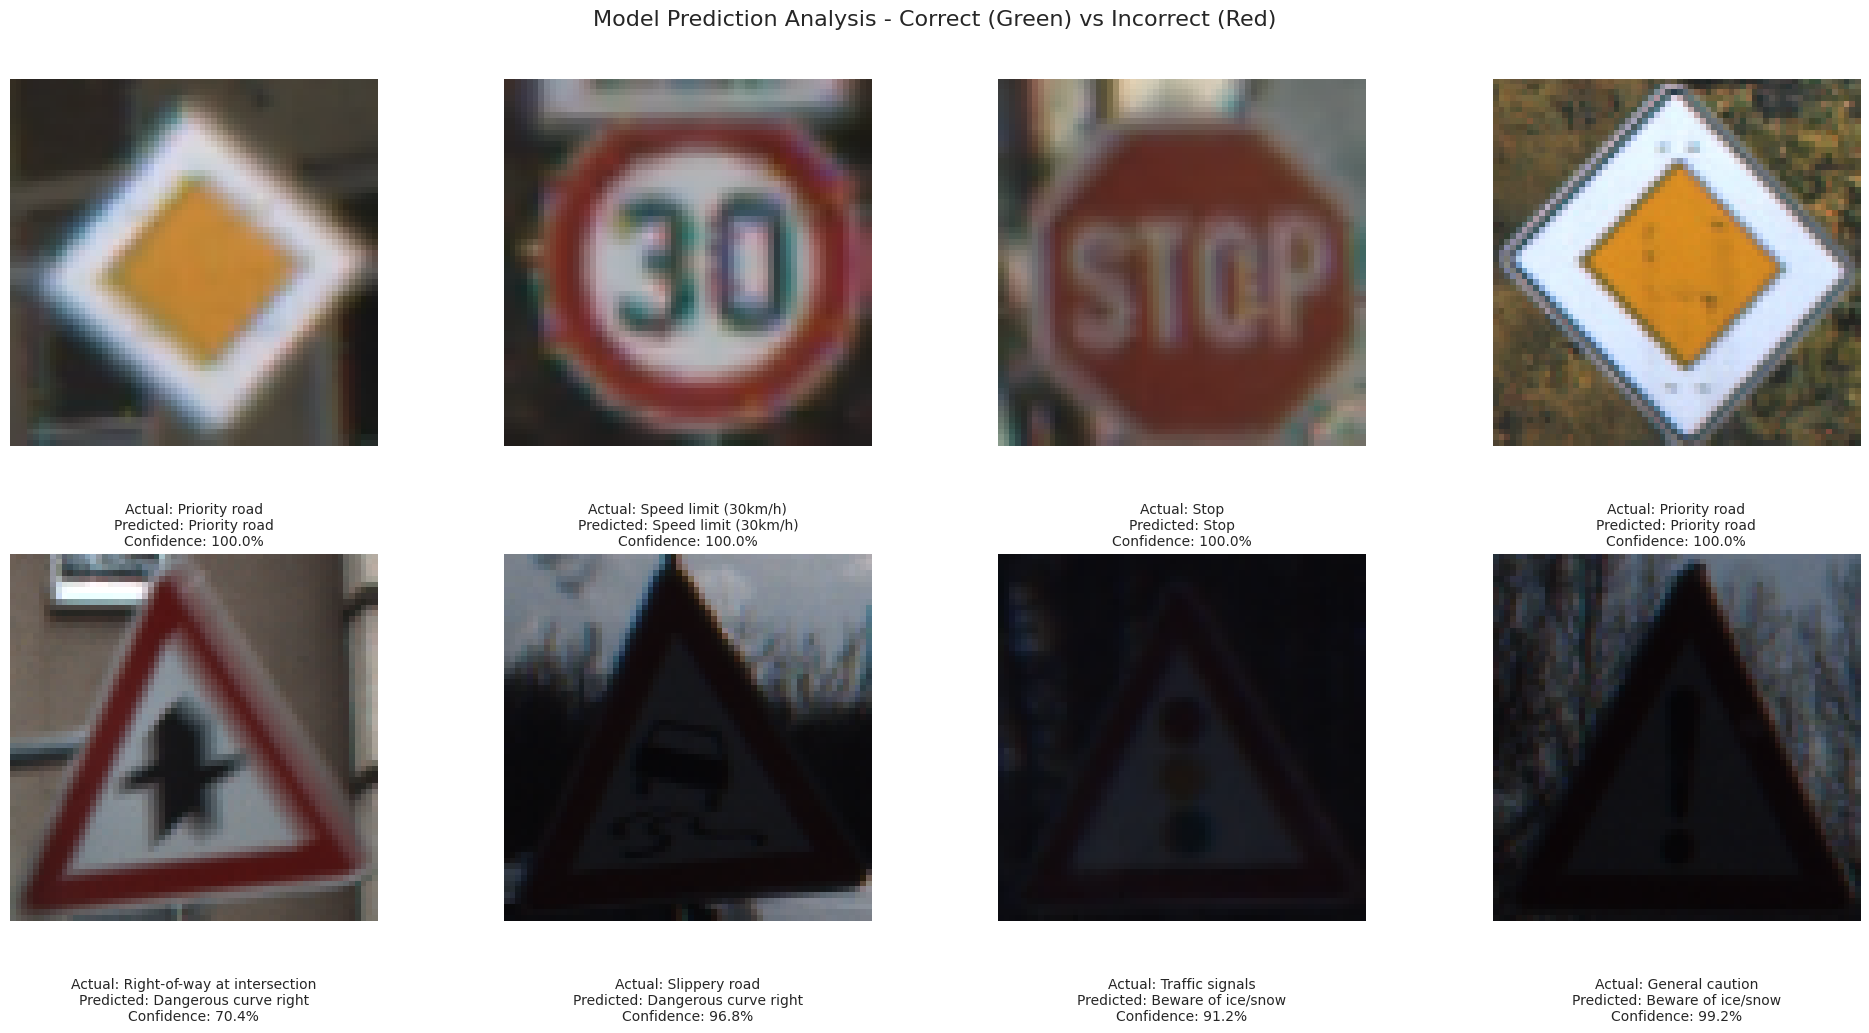

Sample,Actual,Predicted,Confidence,Correct,Top 3 Predictions
10,12 (Priority road),12 (Priority road),100.0%,✓,"Priority road: 100.0%, No passing for vehicles over 3.5 tons: 0.0%, Roundabout mandatory: 0.0%"
92,1 (Speed limit (30km/h)),1 (Speed limit (30km/h)),100.0%,✓,"Speed limit (30km/h): 100.0%, Speed limit (80km/h): 0.0%, Speed limit (50km/h): 0.0%"
129,14 (Stop),14 (Stop),100.0%,✓,"Stop: 100.0%, No entry: 0.0%, Speed limit (30km/h): 0.0%"
159,12 (Priority road),12 (Priority road),100.0%,✓,"Priority road: 100.0%, No passing for vehicles over 3.5 tons: 0.0%, Speed limit (100km/h): 0.0%"
27,11 (Right-of-way at intersection),20 (Dangerous curve right),70.4%,✗,"Dangerous curve right: 70.4%, Bicycles crossing: 21.6%, Road work: 4.7%"
158,23 (Slippery road),20 (Dangerous curve right),96.8%,✗,"Dangerous curve right: 96.8%, Beware of ice/snow: 1.0%, General caution: 0.7%"
25,26 (Traffic signals),30 (Beware of ice/snow),91.2%,✗,"Beware of ice/snow: 91.2%, General caution: 5.0%, Traffic signals: 2.0%"
130,18 (General caution),30 (Beware of ice/snow),99.2%,✗,"Beware of ice/snow: 99.2%, General caution: 0.7%, Children crossing: 0.0%"



PREDICTION STATISTICS:
- Total Test Samples: 243
- Correct Predictions: 224 (92.2%)
- Incorrect Predictions: 19 (7.8%)
- Average Confidence (Correct): 97.6%
- Average Confidence (Incorrect): 65.5%


In [48]:
# =============================================
# 9. SAMPLE PREDICTIONS (PROFESSIONAL VISUALIZATION)
# =============================================
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Configure style
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = False
sns.set_palette("deep")

# Select samples (4 correct, 4 incorrect)
np.random.seed(42)
y_pred = np.argmax(model.predict(X_test, verbose=0), axis=-1)
correct_indices = np.random.choice(np.where(y_pred == y_test)[0], 4, replace=False)
incorrect_indices = np.random.choice(np.where(y_pred != y_test)[0], 4, replace=False)
sample_indices = np.concatenate([correct_indices, incorrect_indices])

# Create figure with 2x4 grid
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.patch.set_facecolor('white')  # Ensure white background
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# Visualization parameters
box_props = dict(boxstyle='round', facecolor='white', alpha=0.8, pad=0.5)

# Collect data for table
table_data = []

for i, idx in enumerate(sample_indices):
    row = i // 4
    col = i % 4
    ax = axes[row, col]

    # Get prediction info
    actual = y_test[idx]
    pred = y_pred[idx]
    probs = model.predict(X_test[idx:idx+1], verbose=0)[0]
    confidence = np.max(probs)
    is_correct = pred == actual

    # Display image
    ax.imshow(X_test[idx].squeeze() if X_test[idx].shape[-1] == 1 else X_test[idx])

    # Add border and annotation
    border_color = '#2ecc71' if is_correct else '#e74c3c'  # Green if correct, Red if incorrect
    for spine in ax.spines.values():
        spine.set_edgecolor(border_color)
        spine.set_linewidth(3)

    # Add info box
    info_text = (f"Actual: {class_names[actual]}\n"
                f"Predicted: {class_names[pred]}\n"
                f"Confidence: {confidence:.1%}")
    ax.text(0.5, -0.15, info_text, transform=ax.transAxes,
            ha='center', va='top', bbox=box_props)

    ax.axis('off')

    # Store data for table
    top_3 = np.argsort(probs)[-3:][::-1]
    table_data.append([
        idx,
        f"{actual} ({class_names[actual]})",
        f"{pred} ({class_names[pred]})",
        f"{confidence:.1%}",
        "✓" if is_correct else "✗",
        ", ".join([f"{class_names[cls]}: {probs[cls]:.1%}" for cls in top_3])
    ])

plt.suptitle('Model Prediction Analysis - Correct (Green) vs Incorrect (Red)',
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Create styled HTML table
table_html = """
<style>
    .prediction-table {
        width: 100%;
        border-collapse: collapse;
        margin: 25px 0;
        font-size: 0.9em;
        font-family: sans-serif;
        box-shadow: 0 0 20px rgba(0, 0, 0, 0.15);
    }
    .prediction-table thead tr {
        background-color: #3498db;
        color: white;
        text-align: left;
    }
    .prediction-table th,
    .prediction-table td {
        padding: 12px 15px;
    }
    .prediction-table tbody tr {
        border-bottom: 1px solid #dddddd;
    }
    .prediction-table tbody tr:nth-of-type(even) {
        background-color: #f3f3f3;
    }
    .prediction-table tbody tr:last-of-type {
        border-bottom: 2px solid #3498db;
    }
    .correct {
        color: #2ecc71;
        font-weight: bold;
    }
    .incorrect {
        color: #e74c3c;
        font-weight: bold;
    }
</style>
"""

table_html += "<table class='prediction-table'><thead><tr>"
table_html += "<th>Sample</th><th>Actual</th><th>Predicted</th><th>Confidence</th><th>Correct</th><th>Top 3 Predictions</th></tr></thead><tbody>"

for row in table_data:
    status_class = "correct" if row[4] == "✓" else "incorrect"
    table_html += f"<tr><td>{row[0]}</td><td>{row[1]}</td><td>{row[2]}</td><td>{row[3]}</td><td class='{status_class}'>{row[4]}</td><td>{row[5]}</td></tr>"

table_html += "</tbody></table>"

# Display table
display(HTML(table_html))

# Prediction Statistics
correct_preds = (y_pred == y_test)
incorrect_preds = (y_pred != y_test)

correct_confidences = np.max(model.predict(X_test[correct_preds], verbose=0), axis=1)
incorrect_confidences = np.max(model.predict(X_test[incorrect_preds], verbose=0), axis=1)

# Print detailed statistics
print("\nPREDICTION STATISTICS:")
print(f"- Total Test Samples: {len(y_test)}")
print(f"- Correct Predictions: {np.sum(correct_preds)} ({np.mean(correct_preds):.1%})")
print(f"- Incorrect Predictions: {np.sum(incorrect_preds)} ({np.mean(incorrect_preds):.1%})")
print(f"- Average Confidence (Correct): {np.mean(correct_confidences):.1%}")
print(f"- Average Confidence (Incorrect): {np.mean(incorrect_confidences):.1%}")



### Report Analysis

* According to the confusion matrix, for which sign were the maximum misclassifications observed? Comment on the misclassification, owing to similar appearing traffic signs, if any.
* Comment on the performance of the MLP Classifier
* Discuss the optimal number of layers, activation functions, optimizers etc. that yielded the best accuracy
* Report on training time vs convergence

# WRITE YOUR REPORT BELOW